## Libraries

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime
import math
from numpy.random import choice
import random

from keras import layers, models, optimizers
from keras import backend as K
from collections import namedtuple, deque
import yfinance as yf
import torch

# set the seed for reproducibility
np.random.seed(11)
random.seed(11)
torch.manual_seed(11)

2024-04-05 11:36:11.017501: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Dataset Gaz

In [2]:
# Essayer DJI  (Dow Johns)
stock = 'BZ=F'
start = '2007-07-30'
end = '2024-04-01'

dataset = yf.download(stock, start, end)

[*********************100%%**********************]  1 of 1 completed


## Data cleaning

In [3]:
# Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
dataset.shape

(4137, 6)

In [5]:
set_option('display.width', 100)
dataset.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-07-30,75.849998,76.529999,75.440002,75.739998,75.739998,2575
2007-07-31,75.699997,77.169998,75.669998,77.050003,77.050003,3513
2007-08-01,77.000000,77.059998,74.860001,75.349998,75.349998,3930
2007-08-02,75.220001,76.209999,74.269997,75.760002,75.760002,6180
2007-08-03,75.389999,76.000000,74.529999,74.750000,74.750000,4387


<Axes: xlabel='Date'>

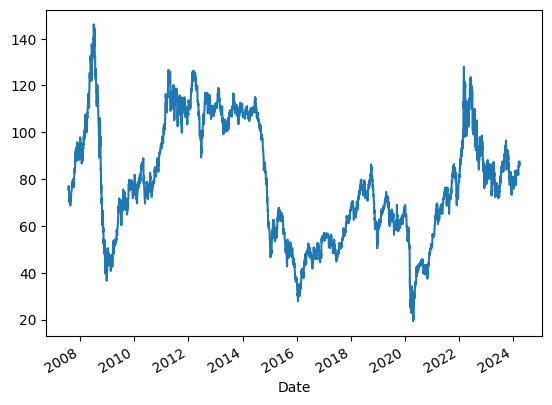

In [6]:
dataset['Close'].plot()

In [7]:
# Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = False


In [8]:
# Fill the missing values with the last value available in the dataset.
dataset=dataset.fillna(method='ffill')
dataset.head(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-07-30,75.849998,76.529999,75.440002,75.739998,75.739998,2575
2007-07-31,75.699997,77.169998,75.669998,77.050003,77.050003,3513


## Feature engineering

In [9]:
# Ajouter Indicateurs RSI MACD
import numpy as np
import pandas as pd

def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    data['MACD'] = short_ema - long_ema
    data['Signal_Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()

def calculate_rsi(data, window=14):
    delta = data['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    data['RSI'] = 100 - (100 / (1 + RS))

calculate_macd(dataset)
calculate_rsi(dataset)
# Drop NaN values that were introduced by the calculations
dataset.dropna(inplace=True)

dataset.columns


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'MACD', 'Signal_Line', 'RSI'], dtype='object')

## Split training & test set 

In [10]:
X=list(dataset["Close"])
X=[float(x) for x in X]

In [11]:
validation_size = 0.2

train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]

## PPO algorithm

In [12]:
import torch
import numpy as np

class PPOMemory:
    def __init__(self, batch_size):
        self.batch_size = batch_size
        self.memory = [] # A single list to store all memories

    def generate_batches(self):
        # Prepare the data for training
        state_arr, action_arr, probs_arr, vals_arr, reward_arr, dones_arr = zip(*self.memory)
        
        # Convert lists to PyTorch tensors
        states = torch.stack(state_arr)
        actions = torch.stack(action_arr)
        probs = torch.stack(probs_arr)
        vals = torch.stack(vals_arr)
        rewards = torch.tensor(reward_arr, dtype=torch.float32)
        dones = torch.tensor(dones_arr, dtype=torch.float32)
        
        # Create batches
        total_length = len(self.memory)
        indices = torch.randperm(total_length)
        
        batches = [{
            'states': states[indices[start:start+self.batch_size]],
            'actions': actions[indices[start:start+self.batch_size]],
            'old_probs': probs[indices[start:start+self.batch_size]],
            'vals': vals[indices[start:start+self.batch_size]],
            'rewards': rewards[indices[start:start+self.batch_size]],
            'dones': dones[indices[start:start+self.batch_size]],
        } for start in range(0, total_length, self.batch_size)]
        
        return batches

    def store_memory(self, state, action, old_prob, val, reward, done):
        self.memory.append((state, action, old_prob, val, reward, done))

    def clear_memory(self):
        self.memory.clear()


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)
    
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        probabilities = F.softmax(self.fc3(x), dim=-1)
        return probabilities

class Critic(nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
    
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        value = self.fc3(x)
        return value

## Agent

In [14]:



class Agent:
    def __init__(self, state_dim, action_dim, gamma=0.99, alpha=0.0003, gae_lambda=0.95, policy_clip=0.2, batch_size=64, n_epochs=10):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda
        self.batch_size = batch_size
        
        self.actor = Actor(state_dim, action_dim)
        self.critic = Critic(state_dim)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=alpha)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=alpha)
        self.memory = []
    
    def evaluate(self, state, action):
        action_probs = self.actor(state)
        dist = Categorical(probs=action_probs)

        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_value = self.critic(state)
        
        return action_logprobs, torch.squeeze(state_value), dist_entropy



    def act(self, state):
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, dtype=torch.float).unsqueeze(0)
        probabilities = self.actor(state)
        dist = Categorical(probs=probabilities)
        action = dist.sample()
        return action.item(), dist.log_prob(action).item()

    
    
    def store_transition(self, state, action, log_prob, reward, done):
        self.memory.append((state, action, log_prob, reward, done))

    
    
    def learn(self):
        rewards = []
        is_terminals = []
        old_states = []
        old_actions = []
        old_logprobs = []

        # Extract information from memory
        for state, action, log_prob, reward, done in self.memory:
            old_states.append(state)
            old_actions.append(action)
            old_logprobs.append(log_prob)
            rewards.append(reward)
            is_terminals.append(done)

        # prints to debug the shape of the tensors
        # print("Before stack")
        # print("old_states", old_states)
        # print("old_actions", old_actions)
        # print("old_logprobs", old_logprobs)

        old_states = torch.stack(old_states)
        # Convert each action and probs to a tensor and then stack
        old_actions = torch.stack([torch.tensor(a, dtype=torch.long) for a in old_actions])
        old_logprobs = torch.stack([torch.tensor(lp, dtype=torch.float) for lp in old_logprobs])
        
        # Normalize the rewards
        rewards = torch.tensor(rewards, dtype=torch.float)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        # Convert is_terminals to tensor
        is_terminals = torch.tensor(is_terminals, dtype=torch.float)

        # Calculating the advantages
        advantages = []
        prev_advantage = 0
        for t in reversed(range(len(rewards))):
            if is_terminals[t]:
                delta = rewards[t] - self.critic(old_states[t])
                prev_advantage = delta
            else:
                delta = rewards[t] + self.gamma * self.critic(old_states[t + 1]) - self.critic(old_states[t])
                prev_advantage = delta + self.gamma * self.gae_lambda * prev_advantage
            advantages.insert(0, prev_advantage)
        advantages = torch.tensor(advantages, dtype=torch.float)
        
        # Normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-7)

        # Optimize policy for K epochs
        for _ in range(self.n_epochs):
            # Evaluating old actions and values
            logprobs, state_values, dist_entropy = self.evaluate(old_states, old_actions)
            
            # Finding the ratio (pi_theta / pi_theta_old)
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.policy_clip, 1+self.policy_clip) * advantages

            # Final loss of clipped objective PPO
            loss = -torch.min(surr1, surr2) + 0.5 * (state_values - rewards)**2 - 0.01 * dist_entropy

            # Take gradient step
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            loss.mean().backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

        
        self.memory.clear()
        

In [15]:
import torch
import numpy as np

class TradingEnvironment:
    def __init__(self, data, initial_balance=10000):
        self.data = data
        self.initial_balance = initial_balance
        self.reset()
    
    def step(self, action):
        done = False
        self.stock_price = self.data[self.current_step]
        
        if action == 1: # Buy
            if self.total_balance >= self.stock_price:
                self.stock_owned += 1
                self.total_balance -= self.stock_price
                
        elif action == 2: # Sell
            if self.stock_owned > 0:
                self.stock_owned -= 1
                self.total_balance += self.stock_price
        
        self.current_step += 1
        if self.current_step >= len(self.data) - 1:
            done = True
        
        next_state = self._get_obs()
        reward = self.total_balance - self.history[-1] # Reward is the change in balance
        self.history.append(self.total_balance)
        
        return next_state, reward, done, {}
    
    def reset(self):
        self.current_step = 0
        self.total_balance = self.initial_balance
        self.stock_owned = 0
        self.stock_price = self.data[0]
        self.history = [self.total_balance]
        return self._get_obs()
    
    def _get_obs(self):
        # Normalize state components for better learning stability
        balance_norm = self.total_balance / self.initial_balance
        price_norm = self.stock_price / self.data[0]
        state = np.array([balance_norm, price_norm, self.stock_owned], dtype=np.float32)
        return torch.tensor(state, dtype=torch.float)
    
    def render(self):
        pass


Reward: 0.000: 100%|██████████| 101/101 [03:18<00:00,  1.97s/it]  


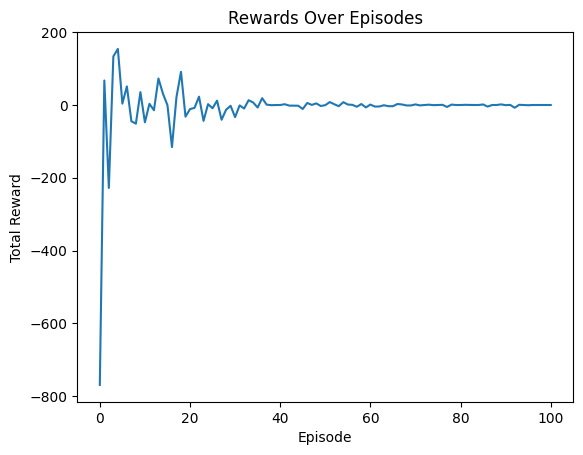

In [16]:
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm


state_dim = 3
action_dim = 3

episode_count = 100


env = TradingEnvironment(data=X_train)
agent = Agent(state_dim=state_dim, action_dim=action_dim, n_epochs=5, batch_size=64)

episode_rewards = []

pbar = tqdm(range(episode_count + 1), desc='Training Progress')
for episode in pbar:
    state = env.reset()  # State is now a torch tensor
    total_episode_reward = 0

    while True:
        
        action, log_prob = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        
        # Store transition in agent memory as tensors
        agent.store_transition(state, action, log_prob, reward, done)
        
        state = next_state
        total_episode_reward += reward

        if done:
            break

    agent.learn()

    episode_rewards.append(total_episode_reward)

    pbar.set_description(f"Reward: {total_episode_reward:.3f}")
    pbar.refresh()

plt.plot(episode_rewards)
plt.title('Rewards Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()


---